In [1]:
import os
import sys
sys.path.append('..')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from medpy.io import load as load_lbl
import random 

from dicomhd import io as dhd_io
from tfvpc.preprocessing.two_dim import extract_2d_patch
from tfvpc.preprocessing.two_dim import extract_2d_patch_labels
from tfvpc.preprocessing.two_dim import extract_annotated_2d_patch
from tfvpc.model.resnet2D import Resnet2DBuilder
%matplotlib inline

In [2]:
n_rows = 32
n_cols = 32
strides = 1
n_classes = 6
vocab = [1,2,3,4,5,6]
n_channel = 1
epoch = 100
batch_size = 128
seed = 2020
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# load image and extract patches
cls_to_vis = 5
path_img = '../../data/dev/val/input/complete/'
path_lbl = '../../data/dev/val/output/complete/'

# path_img = '../../data/dev/train/input/complete/'
# path_lbl = '../../data/dev/train/output/complete/'
# img_fname = 'Hyperlucent-182344-Joe_reviewed_1-611' 
# lbl_fname = 'Hyperlucent-182344-Joe_reviewed_1-692'

# img_fname = 'groundglass-5ff7d9-Jude_reviewed_1-105'
# lbl_fname = 'groundglass-5ff7d9-Jude_reviewed_1-221'

# img_fname = 'Reticular-f377c6-Joe_reviewed_1-461'
# lbl_fname = 'Reticular-f377c6-Joe_reviewed_1-530'

# img_fname = 'groundglass-f94824-Samir_reviewed_1-133'
# lbl_fname = 'groundglass-f94824-Samir_reviewed_1-219'

img_fname = 'Honeycomb-f7cd0c-Samir_reviewed_1-326'
lbl_fname = 'Honeycomb-f7cd0c-Samir_reviewed_1-365'

# img_fname = 'consolidation-000063-Samir_reviewed_1-1024'
# lbl_fname = 'consolidation-000063-Samir_reviewed_1-1104'


out_test_fname = 'test_rec'
out_path = '../data/tfrecods/'
out_ffname = os.path.join(out_path, out_test_fname + '.tfrecords')

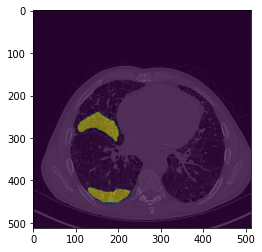

In [4]:
lbl_file_path = os.path.join(path_lbl, lbl_fname)
lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
lbl, label_header = load_lbl(lbl_file_path)
lbl = np.swapaxes(lbl,0,2)
# if lbl.sum() > 0:
# get indices for voxels with ann
idx_with_ann = np.ma.where(lbl.sum(axis=(1,2)) > 0)[0]
img_file_path = os.path.join(path_img, img_fname)
img = dhd_io.read_series(img_file_path)
# show GT
slice_nm=200
slice_nm = idx_with_ann[idx_with_ann.shape[0]//2]
plt.imshow(img.pixel_data[slice_nm], cmap='gray')
plt.imshow(lbl[slice_nm], alpha=0.5)



In [5]:
idx_with_ann

array([121, 122, 123, 124, 125, 126, 127, 150, 151, 152, 153, 154, 155,
       171, 172, 173, 174, 175, 176, 177, 195, 196, 197, 198, 199, 200,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 236,
       237, 238, 239, 240, 241, 249, 250, 251, 252, 253, 254])

In [6]:
#lung segmentation
out_path = os.path.join(path_lbl, lbl_fname)
# seg_fname = 'lung_mask.nii.gz'
seg_fname = 'segmentation_0.nii.gz'
seg_file_path = os.path.join(out_path, seg_fname)
# img = nib.load(seg_file_path)
seg, seg_header = load_lbl(seg_file_path)
seg = np.swapaxes(seg,0,2)
seg[seg==3]=0
# plt.imshow(img.pixel_data[slice_nm,...], cmap='gray')
# plt.imshow(seg[slice_nm,...], alpha=0.5)
idx_with_ann = np.ma.where(seg.sum(axis=(1,2)) > 1024)[0]
img_ann = img.pixel_data[idx_with_ann]
seg_ann = seg[idx_with_ann]
idx_with_ann

array([ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 25

array([130])

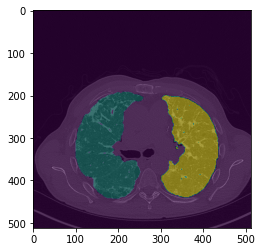

In [7]:
plt.imshow(img_ann[slice_nm,...], cmap='gray')
plt.imshow(seg_ann[slice_nm,...], alpha=0.5)

idx = np.where(idx_with_ann==200)
idx[0] 

In [8]:
def extract_2d_patch(images, sizes, strides=[1, 1], padding='SAME'): 
    images = np.expand_dims(images, [-1])
    timages = tf.convert_to_tensor(images, dtype='float32')
    tpatches = tf.image.extract_patches(timages,
                                        sizes=[1, *sizes, 1],
                                        strides=[1, *strides, 1],
                                        rates=[1, 1, 1, 1],
                                        padding=padding)
    patch = tf.reshape(tpatches, (-1, *sizes, 1))
    return patch

In [9]:
slice_nm

200

In [10]:
#load model
model_fname = '../checkpoints/resnet34-2D-6cls_checkpoint-04.h5'
resnet = Resnet2DBuilder.build_resnet_34((n_rows, n_cols, n_channel), n_classes)
resnet.load_weights(model_fname)
# resnet.summary()
resnet.compile(optimizer='adam', loss= 'categorical_crossentropy',)

lbls = tf.zeros_like(img.pixel_data).numpy()
n_imgs_with_ann = img_ann.shape[0]
# idx_with_ann
with tf.device('/cpu:0'):
    for i in range(0, n_imgs_with_ann):
        print(f'{i}/{n_imgs_with_ann}')
        anns = seg_ann[[i]]
        imgs = img_ann[[i]]
        sizes = [n_rows, n_cols]
        strides = [1, 1]
        dim = len(imgs.shape)
        padding = 'SAME'
        if dim == 3:
            imgs = np.expand_dims(imgs, [-1])
            anns = np.expand_dims(anns, [-1])
        elif dim == 2:
            imgs = np.expand_dims(imgs, [0, -1])
            anns = np.expand_dims(anns, [0, -1])
        else:
            raise ValueError('Inputs imgs can only be onf dim 2 or 3.')

        # timages = tf.convert_to_tensor(imgs, dtype='float32')
        patches_i = tf.image.extract_patches(imgs,
                                            sizes=[1, *sizes, 1],
                                            strides=[1, *strides, 1],
                                            rates=[1, 1, 1, 1],
                                            padding=padding)
        anns_i = tf.image.extract_patches(anns,
                                            sizes=[1, *sizes, 1],
                                            strides=[1, *strides, 1],
                                            rates=[1, 1, 1, 1],
                                            padding=padding)

        patches_i = tf.reshape(patches_i, (-1, *sizes, 1))
        anns_i = tf.reshape(anns_i, (-1, *sizes, 1))
        indices_i = tf.constant(list(range(patches_i.shape[0])), dtype=tf.int32)

        ann_ratio = tf.math.count_nonzero(anns_i, axis=[1, 2, 3]) / (sizes[0] * sizes[1])
        center_pixel_ann = anns_i[:, sizes[0]//2+1, sizes[0]//2+1, 0]

        mask = center_pixel_ann > 0
    #     mask = ann_ratio > 0.8

        patches_with_ann_i = patches_i[mask]
        indices_with_ann_i = indices_i[mask]

        min_value = -1200
        max_value = -150
    #     patches_with_ann_i = tf.clip_by_value(patches_with_ann_i, min_value, max_value)
        patches_with_ann_i = tf.math.subtract(patches_with_ann_i, min_value) / (max_value - min_value)
        patch_probs_with_ann_i = resnet.predict(patches_with_ann_i, 8, verbose=1, workers=10, use_multiprocessing=True)
        patch_lbls_with_ann_i = np.argmax(patch_probs_with_ann_i, axis=1) + 1
        lbls_i = tf.zeros(shape=(patches_i.shape[0]))
        lbls_i = tf.tensor_scatter_nd_add(
            lbls_i, 
            indices=tf.expand_dims(indices_with_ann_i, -1), 
            updates=patch_lbls_with_ann_i
        )
        lbls_i = tf.reshape(lbls_i, anns.shape)
        lbls_c = lbls_i[0, ..., 0] 
        mask = lbls_c != cls_to_vis
        lbls_c = np.where(mask, 0, lbls_c)
        lbls[idx_with_ann[i], ...] = lbls_c

    

    


0/331
121/121 [==============================] - 4s 24ms/step
1/331
144/144 [==============================] - 3s 24ms/step
2/331
165/165 [==============================] - 4s 24ms/step
3/331
189/189 [==============================] - 4s 24ms/step
4/331
221/221 [==============================] - 5s 24ms/step
5/331
243/243 [==============================] - 6s 24ms/step
6/331
269/269 [==============================] - 6s 24ms/step
7/331
293/293 [==============================] - 7s 23ms/step
8/331
321/321 [==============================] - 7s 21ms/step
9/331
360/360 [==============================] - 9s 24ms/step
10/331
397/397 [==============================] - 9s 24ms/step
11/331
427/427 [==============================] - 10s 24ms/step
12/331
473/473 [==============================] - 11s 24ms/step
13/331
523/523 [==============================] - 12s 24ms/step
14/331
569/569 [==============================] - 13s 24ms/step
15/331
620/620 [==============================] - 15s 24ms/st

6379/6379 [==============================] - 150s 23ms/step
124/331
6372/6372 [==============================] - 151s 24ms/step
125/331
6361/6361 [==============================] - 150s 24ms/step
126/331
6339/6339 [==============================] - 151s 24ms/step
127/331
6324/6324 [==============================] - 150s 24ms/step
128/331
6308/6308 [==============================] - 149s 24ms/step
129/331
6302/6302 [==============================] - 149s 24ms/step
130/331
6297/6297 [==============================] - 148s 24ms/step
131/331
6289/6289 [==============================] - 148s 24ms/step
132/331
6276/6276 [==============================] - 148s 24ms/step
133/331
6275/6275 [==============================] - 129s 21ms/step
134/331
6270/6270 [==============================] - 147s 23ms/step
135/331
6270/6270 [==============================] - 148s 24ms/step
136/331
6262/6262 [==============================] - 129s 21ms/step
137/331
6250/6250 [==============================] - 148

4676/4676 [==============================] - 111s 24ms/step
244/331
4630/4630 [==============================] - 109s 24ms/step
245/331
4582/4582 [==============================] - 109s 24ms/step
246/331
4527/4527 [==============================] - 107s 24ms/step
247/331
4482/4482 [==============================] - 106s 24ms/step
248/331
4436/4436 [==============================] - 104s 24ms/step
249/331
4395/4395 [==============================] - 91s 21ms/step
250/331
4362/4362 [==============================] - 103s 24ms/step
251/331
4313/4313 [==============================] - 89s 21ms/step
252/331
4266/4266 [==============================] - 101s 24ms/step
253/331
4227/4227 [==============================] - 100s 24ms/step
254/331
4182/4182 [==============================] - 99s 24ms/step
255/331
4116/4116 [==============================] - 98s 24ms/step
256/331
4070/4070 [==============================] - 97s 24ms/step
257/331
4015/4015 [==============================] - 94s 23ms

In [28]:
out_path ='../../data/dev/val/output/complete/Honeycomb-f7cd0c-Samir_reviewed_1-365/lbls'
np.save(out_path, lbls)

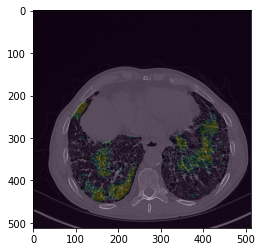

In [30]:
plt.imshow(img.pixel_data[138,...], cmap = 'gray')
plt.imshow(lbls[138,...], alpha=0.2)

In [25]:
out_path

'../../data/dev/val/output/complete/Honeycomb-f7cd0c-Samir_reviewed_1-365'

In [ ]:
# %matplotlib notebook
# cls_to_vis = 5
# fig, axes = plt.subplots(1, 4, figsize=(10, 5))
# axes[0].imshow(img_ann[slice_nm,...], cmap='gray')
# axes[0].imshow(seg_ann[slice_nm,...], alpha=0.5)
# axes[1].imshow(imgs[0, ..., 0], cmap='gray')
# axes[1].imshow(lbl[slice_nm], alpha=0.5)

# axes[2].imshow(imgs[0, ..., 0], cmap='gray')
# axes[2].imshow(lbls_i[0, ..., 0], alpha=0.5)
# #cls to vis
# axes[3].imshow(imgs[0, ..., 0], cmap='gray')
# axes[3].imshow(lbls_c, alpha=0.5)

In [ ]:
def create_rgba_texture_array(texture_map_slice, color_dict, patterns):
    """Creates an 3D array of RGBA values representing the textures in texture_map_slice

    # Arguments
        texture_map_slice (numpy.ndarray): one slice of texture classification map

        colors (dict): dictionary containing color corresponding to each
            texture name, indexed by texture name

        patterns (list): texture names
    """
    rgba_shape = np.asarray(texture_map_slice.shape + (4,))
    rgba = np.zeros(rgba_shape, dtype="uint8")  # order='F'?
    for texture_key, pattern in enumerate(patterns, start=1):
        # Color array is [r, g, b, a] for texture
        color_array = color_dict[pattern]["color"] + [color_dict[pattern]["alpha"]]
        for idx, rgba_val in enumerate(color_array):
            if isinstance(rgba_val, float):
                # scale alpha value
                rgba_val = int(rgba_val * 255)
            rgba[texture_map_slice == texture_key, idx] = rgba_val

    return rgba

In [ ]:
# write out results
# ct_pixel_data = image_processing.convert_pixel_data_to_SPL(ct_pixel_data, ct_series)
# voxel_spacing = dicom_spatial_metadata.get_voxel_spacing(ct_series)
# origin = dicom_spatial_metadata.get_origin(ct_series)

# # Export CT
# if debug_dir:
#     output_nifti_file = os.path.join(debug_dir, "ct.nii.gz")
#     io.np_export_nifti(
#         output_nifti_file, ct_pixel_data, spacing=voxel_spacing, origin=origin
#     )